### Read OISST v2 data via Thredds and test the marineHeatWaves algorithm

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import xarray as xr
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

['https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1981.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1982.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1983.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1985.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1986.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1987.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1988.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1989.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1990.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.

In [3]:
%%time
data = xr.open_mfdataset(files)

CPU times: user 536 ms, sys: 80 ms, total: 616 ms
Wall time: 2.77 s


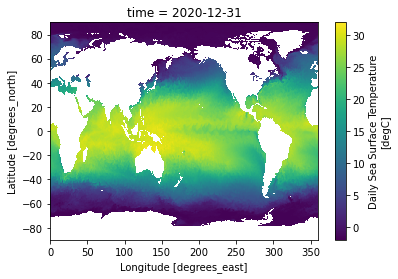

In [4]:
%matplotlib inline
data.sst[-1,:].plot(vmin=-2,vmax=32)

### Marine Heatwave Detection
The marineHeatWaves (mhw) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (detect) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs.

#### Case study #1: 2011 Western Australia event
As an example, let's load a daily time series of SST off Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S) over the 1982 to 2014 period, remotely-sensed from the AVHRR satellite platform:

In [18]:
%%time
wa_ds = data.sst.sel(lon = 112.5, lat = -29.5, 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 389 ms, sys: 66.9 ms, total: 456 ms
Wall time: 5min 34s


In [19]:
wa_ds.to_netcdf('wa_ds.nc')

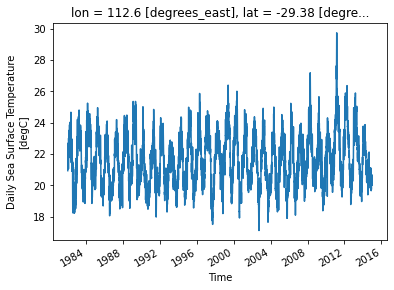

In [20]:
wa_ds.plot()

Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [21]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [24]:
mhws, clim = mhw.detect(t, wa_ds.values)

This algorithm has detected the following number of MHW events:

In [26]:
mhws['n_events']

60

The first ten events, for example, have the following maximum intensities (in C)  

In [27]:
mhws['intensity_max'][0:10]

[1.9759563938263902,
 2.1255383645334582,
 2.241348082019435,
 1.2863466816563793,
 1.8312707716418863,
 1.5018472363871922,
 2.2082389708488286,
 1.1157563117242653,
 1.690619499452648,
 1.9938329881237422]

Let's have a look at some properties of the event with the largest maximum intensity

In [29]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws['duration'][ev], 'days')
print ('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.483709366090839 deg. C
Average intensity: 3.1762778888865806 deg. C
Cumulative intensity: 193.7529512220814 deg. C-days
Duration: 61 days
Start date: 06 February 2011
End date: 07 April 2011


This turns out to be the infamous 2011 MHW off WA. Let's plot the SST time series over the full record and also have a closer look at the identified MHW event:

Text(0, 0.5, 'SST [$^\\circ$C]')

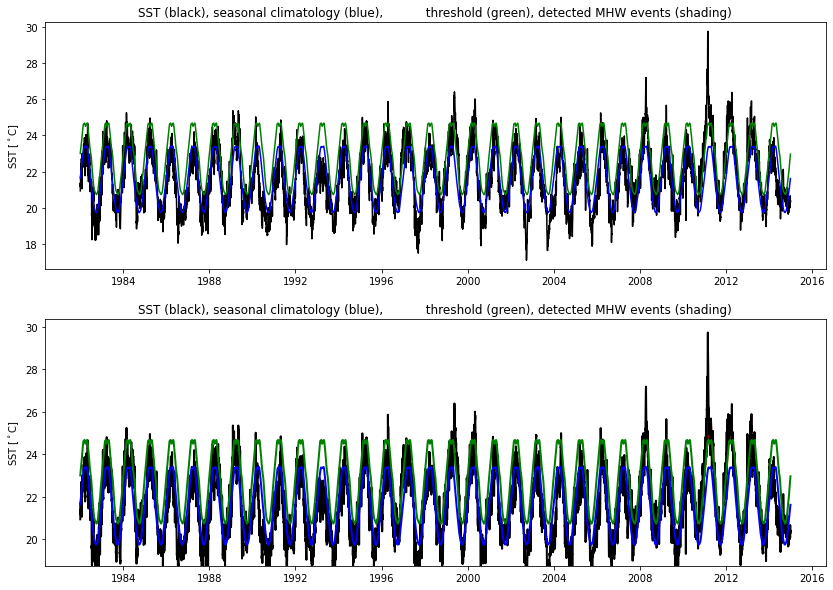

In [37]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, wa_ds.values, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(t[0], t[-1])
plt.ylim(wa_ds.min()-0.5, wa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2011 WA event) and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, wa_ds, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [43]:
len(mhws['category'])

60